In [7]:
%%html
<style>
body {
    font-family: "Helvetica Neue";
}
</style>

# Project 1: Modeling Populations

Alex Wenstrup and Jasmine Kamdar

September 27, 2018

## Questions:

- Why was there a population rise in Germany between 1950-1970?
    - What was the effect on the population of Portugal (one of the 7 locations where migrant workers were coming to Germany from) during this time?

## Methodology:
- Overlay a generic logistic growth model on top of the German population in the specified date range
- Calculate and plot residuals to identify where the greatest deviations from logistic growth occurred
- Research significant events in Germany within the specified date range
- Add data and model for other affected population as a way to validate our results
- Adjust models for both populations to account for found events
- Plot residuals for new models, compare to residuals for old model, and evaluate effectiveness of new model

### Note: This report includes all processes done for the Portuguese population inline with those done for the German population. That is not indicative of our actual order of operations, rather it is done for continuity in this report.

## Step 1: Find and Import data

We obtained our data from gapminder.com, an established resource and tool for tracking world demographic data. After downloading their world population data as an excel spreadsheet, we removed unnecesary rows and columns so that our CSV file contained only data relevant to our model.<br>
Source: https://www.gapminder.org/data/

In [8]:
import pandas
from modsim import *

ModuleNotFoundError: No module named 'modsim'

In [ ]:
rows = 64

ger_port_data = pandas.read_csv('germany_portugal.csv', 
                               low_memory=False, 
                               usecols=[0, 1, 2], 
                               nrows=rows, 
                               index_col=0)

#Import data from saved CSV file
#Note that Portuguese data was not imported originally, only later in the project

In [ ]:
germany = ger_port_data.Germany / 1e6
portugal = ger_port_data.Portugal / 1e6

#Save data from DataFrame, in millions

In [4]:
plot(germany, label = 'German Population')

decorate(xlabel = 'Time (years)', ylabel = 'Population (millions)')

#Plot of Germany's population over time

NameError: name 'plot' is not defined

In [5]:
plot(portugal, label = 'Portuguese Population')

decorate(xlabel = 'Time (years)', ylabel = 'Population (millions)')

#Plot of Portugal's population over time

NameError: name 'plot' is not defined

## Step 2: Overlay a generic growth model

We had to pick some generic growth model from which to calculate the largest deviations from expected population. For this purpose, we chose a simple quadratic growth model because of its face validity, easy workability, and general good fit.

In [47]:
tg_0=get_first_label(germany) #Beginning of German data
tg_end=get_last_label(germany) #End of German Data
pg_0=get_first_value(germany) #German opulation at tg_0

tp_0=get_first_label(portugal) #Beginning on Portuguese data
tp_end=get_last_label(portugal) #End of Portuguese data
pp_0=get_first_value(portugal) #Portuguese population at tp_0

In [48]:
system=System(tg_0=tg_0,       #Setting a beginning time range value for Germany
             tg_end=tg_end,    #Setting an end time range for Germany
             pg_0=pg_0,        #Setting a beginning population range value for Germany
             tp_0=tp_0,        #Setting a beginning time range value for Portugal
             tp_end=tp_end,    #Setting an end time range value for Portugal
             pp_0=pp_0,        #Setting a beginning population range value for Portugal
             maxG=85,          #Approximate max German population
             maxP=12,          #Approximate max Portuguese population
             aG=.00035,        #Germany's population growth rate
             aP=.0015)         #Portugal's population growth rate

Here we create an update function that models each year's population growth as a function of current population, an assumed maximum population, and some groth constant aG or aP.

In [49]:
def update_func_quad_germany(pop, t, system):           #Defining a general quadratic growth function for Germany
    net_growth_germany=system.aG*pop*(system.maxG-pop)  
    return pop+net_growth_germany                  

def update_func_quad_portugal(pop, t, system):          #Defining a general quadratic growth function for Portugal
    net_growth_portugal=system.aP*pop*(system.maxP-pop)
    return pop+net_growth_portugal

Here we create our run_simulation functions, which iterate the our update function through the timeframe for which we have data, and return the results.

In [50]:
def run_simulation_g(system, update_func_g):                  #Defining a function that runs simulation for germany
    
    resultsg=TimeSeries()                                     #Creating a time series
    resultsg[system.tg_0]=system.pg_0                         #Setting the first value in the time series 
    
    for t in linrange(system.tg_0, system.tg_end):            #Setting the rest of the values in the time series 
        resultsg[t+1] = update_func_g(resultsg[t], t,system)
        
    return resultsg

def run_simulation_p(system, update_func_p):                  #Defining a function that runs simulation for Portugal
    
    resultsp=TimeSeries()                                     #Creating a time series
    resultsp[system.tp_0]=system.pp_0                         #Setting the first value in the time series 
    
    for t in linrange(system.tp_0, system.tp_end):            #Setting the rest of the values in the time series 
        resultsp[t+1] = update_func_p(resultsp[t], t,system)
        
    return resultsp

In [51]:
def plot_results_g(real_g, mod_g):                      #Defining a function that plots Germany's actual and model populations
    plot(real_g, ':', label='Germany')
    plot(mod_g, label='Germany Model')
    
    decorate(xlabel='Year', 
             ylabel='Population (millions)')
    
def plot_results_p(real_p, mod_p):                      #Defining a function that plots Portugal's actual and model populations
    plot(real_p, ':', label='Portugal')
    plot(mod_p, label='Portugal Model')
    
    decorate(xlabel='Year', 
             ylabel='Population (millions)')

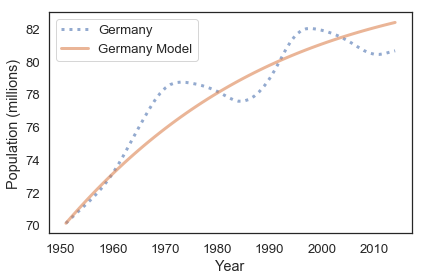

In [52]:
resultsg = run_simulation_g(system, update_func_quad_germany)  #Runs the function that will plot Germany's model

plot_results_g(germany, resultsg)                              #Plots Portugal's actual and general quad popuations

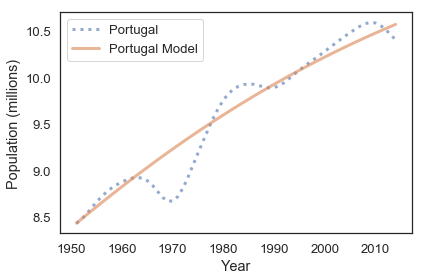

In [53]:
resultsp = run_simulation_p(system, update_func_quad_portugal)   #Runs the function that will plot Portugal's model

plot_results_p(portugal, resultsp)                               #Plots Portugal's actual and general quad popuations

Note that these models were not created by linearizing our data and  fitting a least squares regression line. We eyeballed these models, because their exact precision was not important.

## Step 3: Plot residuals to identify large deviations

At this point, it was already fairly evident where the largest deviations were from our model, but a relative residual plot would serve two purposes:
- It made it even easier to see deviations from expected growth
- It gave us a means to compare our adjusted model to our generic model

To calculate a relative residual, we divided the residual from our model by the true population at the time.

In [54]:
def get_relative_resid(real, model):                                  #Defines a function that will give us the residual plot 
    results = TimeSeries()                                            #for the general quadratic model
    
    for t in linrange(get_first_label(real), get_last_label(real)):   #Takes the difference of the real populations and general
        results[t] = (real[t] - model[t]) / real[t]                   #quadratic model and divides by the real population
        
    return results

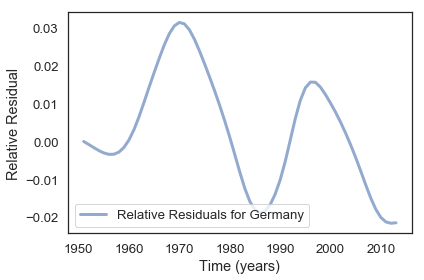

In [55]:
german_model = run_simulation_g(system, update_func_quad_germany)     
german_resid = get_relative_resid(germany, german_model)           #Creates Portugal's residual model for general quadratic model

plot(german_resid, label = 'Relative Residuals for Germany')       #Plots Germany's residual plot for the general quadratic model

decorate(xlabel = 'Time (years)', ylabel = 'Relative Residual')

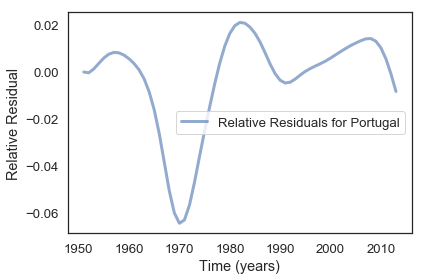

In [56]:
portuguese_model = run_simulation_p(system, update_func_quad_portugal)
portuguese_resid = get_relative_resid(portugal, portuguese_model) #Creates Portugal's residual model for general quadratic model

plot(portuguese_resid, label = 'Relative Residuals for Portugal') #Plots Portugal's residual plot for the general quadratic model

decorate(xlabel = 'Time (years)', ylabel = 'Relative Residual')

## Step 4: Research!

Now that we have identified 1970, and the buildup to that date, as a significant deviation from expected population, we knew exactly where to look for population events. A quick google search for 'german population boom 1970' led us to this study:<br>
http://countrystudies.us/germany/84.htm<br>
which we then verified with this New York Times article:<br>
https://www.nytimes.com/1984/08/19/magazine/germany-s-guest-workers.html<br>

### Gastarbeiter 
We found that due to Germany's booming economy in the 1950's, many workers were brought in to work in a variety of industries, including infrastructure. Between 1955 and 1973, seven countries, including Portugal, entered agreements with Germany which made it easier for workers to travel to Germany for work. These workers, called gastarbeiter, were originally meant to stay only for 3 years, though many of them stayed in Germany permanently.

## Step 5: A New Model

Knowing the Gastarbeiter migration event, we created a model for each of the countries with the expectation of population growth and decline. The first step for creating this new model was coding a function of the rate of migrants flowing into Germany. 

In [98]:
def travel_popularity(t):       #Defines the function of migrants flowing into Germany
    pop =  -1*(t-1960)*(t-1973) #5 year delay for program to become significantly popular
    if t <= 1960 or t >= 1973:  #Sets the time frame
        return 0
    else:
        return pop

In [9]:
results = TimeSeries()                #Creates the time series 
time = linrange(1955, 1974)          
for t in time:                        #Populates TimeSeries with popularity of migrant program
    results[t] = travel_popularity(t) 
    
plot(results)

NameError: name 'TimeSeries' is not defined

This function starts off at 1960 rather than the actual start date of 1955 because we predicted that the program did not get popular enough to significantly affect the population. The shape of the graph is then a parabolic curve because the popularity would highten in the middle years of the program and then slowly decrease to 0 as the German economy suffered in the early 70's. 

We made a new system to account for new variables.

In [100]:
system=System(tg_0=tg_0,        #Setting a beginning time range value for Germany
             tg_end=tg_end,     #Setting an end time range for Germany
             pg_0=pg_0,         #Setting a beginning population range value for Germany
             tp_0=tp_0,         #Setting a beginning time range value for Portugal
             tp_end=tp_end,     #Setting an end time range value for Portugal
             pp_0=pp_0,         #Setting a beginning population range value for Portugal
             maxG=85,           #Approximate maximum population of Germany
             maxP=12,           #Approximate maximum population of Germany
             aG=.00035,         #Germany's population growth rate
             aP=.0015,          #Portugal's population growth rate
             c=0.015,           #Popularity of migrant program
             stayrate=2/3,      #the fraction of migrants who stayed in Germany after 3 years
             propport=1/5)      #the fraction of migrants coming to Germany from Portugal

To create our new model for Germany, we added our travel_popularity function to our generic quadratic model. We also accounted for 1/3 of migrants leaving Germany after 3 years. 


In [87]:
def update_func_migrant_germany(pop, t, system):          #Creates a function that adds travel_popularity * a constant to 
                                                          #Germany's general quadratic function
    net_growth_germany = system.aG*pop*(system.maxG-pop)
    net_growth_germany += travel_popularity(t)*system.c
    net_growth_germany -= travel_popularity(t-3)*system.c*system.stayrate #and subtracts 1/3 of travel_popularity after 3 years
    #Research shows ~2/3 of people stayed in the country bc of the booming economy
    
    return pop+net_growth_germany 

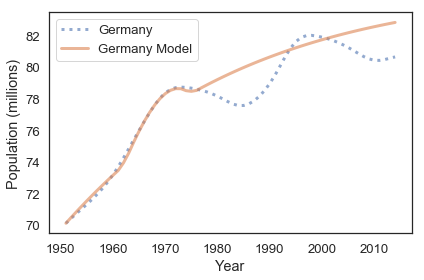

In [88]:
resultsg = run_simulation_g(system, update_func_migrant_germany)

plot_results_g(germany, resultsg)                       #Plots Germany's new model alongside actual population

To create our new model for Portugal we subtracted people from the generic model according to the travel_popularity fuction. We also added back the 1/3 of the workers who returned to Portugal. We also accounted for the fact that Portugal was one of seven countries from which migrants went to Germany by multiplying the function by 1/5. This assumes that 1/5 of the migrants in Germany came from Portugal. 

In [91]:
def update_func_migrant_portugal(pop, t, system):         #Creates a function that subtracts travel_popularity by a constant to 
                                                          #Portugal's general quadratic function
    
    net_growth_portugal = system.aP*pop*(system.maxP-pop)
    net_growth_portugal -= travel_popularity(t)*system.c*system.propport
    net_growth_portugal += travel_popularity(t-3)*system.c*system.stayrate*system.propport #and adds 1/3 of travel_popularity
                                                                                           # after 3 years
    #Portugal was one of seven countries sending workers to Germany
    
    return pop+net_growth_portugal

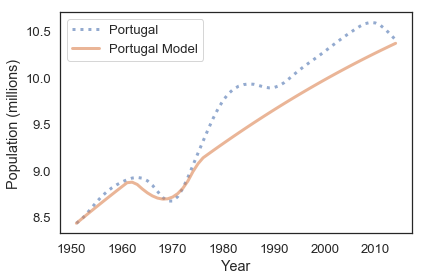

In [92]:
resultsp = run_simulation_p(system, update_func_migrant_portugal)

plot_results_p(portugal, resultsp)                                  #Plots Portugal's new model alongside actual population

To see how our new model compared with our generic model, we made two residual plots that noted the difference between the our models and the actual data.

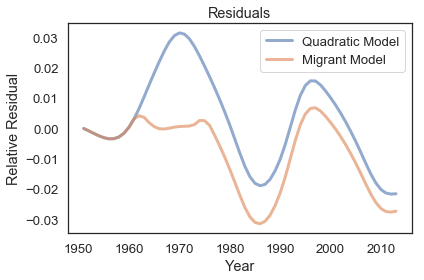

In [93]:
german_model_quad = run_simulation_g(system, update_func_quad_germany)
german_model_migrant = run_simulation_g(system, update_func_migrant_germany)   #Creates residual model for Germany's quad model

german_resid_quad = get_relative_resid(germany, german_model_quad)
german_resid_migrant = get_relative_resid(germany, german_model_migrant)       #Creates residual model for Germany's new model


plot(german_resid_quad, label='Quadratic Model')                               #Plots residuals of Germany's quadratic model
plot(german_resid_migrant, label='Migrant Model')                              #Plots residuals of Germany's new model

decorate(xlabel='Year', ylabel='Relative Residual', title='Residuals');

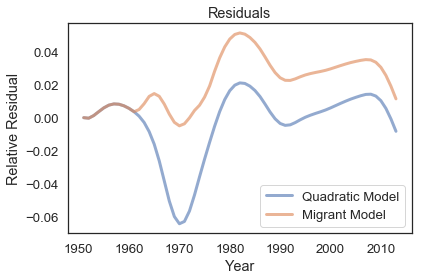

In [94]:
portuguese_model = run_simulation_p(system, update_func_quad_portugal)          
portuguese_resid_quad = get_relative_resid(portugal, portuguese_model)          #Creates residual model for Portugal's quad model

portuguese_model = run_simulation_p(system, update_func_migrant_portugal)
portuguese_resid_migrant = get_relative_resid(portugal, portuguese_model)       #Creates residual model for Portugal's new model

plot(portuguese_resid_quad, label='Quadratic Model')                            #Plots residuals of Portugal's quadratic model
plot(portuguese_resid_migrant, label='Migrant Model')                           #Plots residuals of Portugal's new model

decorate(xlabel='Year', ylabel='Relative Residual', title='Residuals');

## Interpretation:

- The quadratic growth model roughly approximated the population curve, though there were clearly variations in the population that were not accounted for in that model
- This growth model, along with its residual plot, showed us when significant deviations in populations occurred
- The new model almost perfectly accounted for the change in Germany's population, and accounted for over half of the population decrease in Portugal
- Our migrant model was successful because in the time range 1955-1973, the residuals were significantly lower than those of a generic logistic model

A few causes of error include:

- We were unsure how many migrants workers stayed in Germany
- We were unsure how the popularity of migration changed with time
- We were unsure what percentage of the migrant workers in Germany came from Portugal

## Sources

- https://www.gapminder.org/data/
- http://countrystudies.us/germany/84.htm
- https://www.nytimes.com/1984/08/19/magazine/germany-s-guest-workers.html